# Test API

To test the API submission process

In [1]:
import traceback
import numpy as np
import pandas as pd
#import datatable as dt
import gc
import time
import os
import xgboost as xgb
import talib as ta
from script.crypto_API import *

## Model Version

In [2]:
ASSET_DETAILS_CSV = './data/asset_details.csv'
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

version = 40
retrained = True
if retrained:
    MOD_FOLDER = "./trainedXGB/retrained" + f"/model_nof_{version}_sub_sub"
else:
    MOD_FOLDER = "./trainedXGB" + f"/model_nof_{version}"

model from ./trainedXGB/retrained/model_nof_40_sub_sub


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

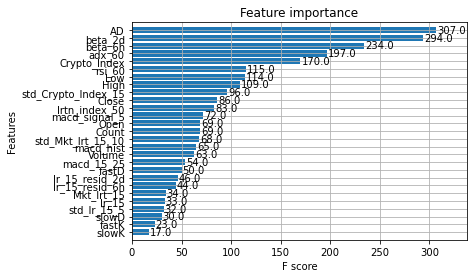

In [3]:
from os.path import exists
def model_reload_train():
    print(f'model from {MOD_FOLDER}')
    models = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        model_file = MOD_FOLDER + f"/model_{asset_id}.json"
        if exists(model_file):
            model = xgb.Booster()
            model.load_model(model_file)
            models[asset_id] = model
    return models

models = model_reload_train()
xgb.plot_importance(models[1],height=0.8)

## get_features

In [4]:
# psets34 = dict(zip(['lrtn','fastk1','fastk2','adx','macd_s','macd_l','rsi','std_Crypto_Index','std_lr_15','std_Mkt_lrt_15'],
#                    [15, 15, 5, 30, 5, 25, 60, 5, 15, 30]))
      
import pickle
with open(MOD_FOLDER+f"/feature_best{version}", "rb") as f:
    psets=pickle.load(f)
    
if version < 44:
    psets['vol_sum'] = 0

psets

{'std_lr_15': 5,
 'std_Mkt_lrt_15': 10,
 'std_Crypto_Index': 15,
 'rsi': 60,
 'macd_sig': 5,
 'macd_s': 15,
 'macd_l': 25,
 'lrtn': 50,
 'fastk2': 15,
 'fastk1': 5,
 'beta_s': '6h',
 'beta_l': '2d',
 'adx': 60,
 'vol_sum': 0}

In [5]:
def log_return(series, periods=5):
    return np.log(series).diff(periods)


def lag_features(df, fastk1,fastk2,adx,macd_s,macd_l,macd_sig,rsi,vol_sum,std_Crypto_Index,std_lr_15,std_Mkt_lrt_15, **kwargs):    
    if vol_sum >0 :
        df[f'vol_sum_{vol_sum}'] = ta.SMA(df['Volume'],vol_sum)*vol_sum
    ####TECH indicators
    df['slowK'], df['slowD'] = ta.STOCH(df.High, df.Low, df.Close, 
                                        fastk_period=fastk1, slowk_period=int(3*fastk1/5), slowd_period=int(3*fastk1/5),
                                        slowk_matype=0, slowd_matype=0)
    df['fastK'], df['fastD'] = ta.STOCHF(df.High, df.Low, df.Close,
                                         fastk_period=fastk2, fastd_period=int(3*fastk2/5), 
                                         fastd_matype=0)
    df[f'macd_{macd_s}_{macd_l}'],df[f'macd_signal_{macd_sig}'], df['macd_hist'] = \
                ta.MACD(df['Close'],fastperiod=macd_s, slowperiod=macd_l, signalperiod=macd_sig)
    ##smoothing sensitive ADX 150, RSI250, AD unKNOWN
    df[f'rsi_{rsi}'] = ta.RSI(df['Close'], timeperiod=rsi)
    df[f'adx_{adx}'] = ta.ADX(df['High'], df['Low'],df['Close'], timeperiod=adx)
    df['AD'] = ta.AD(df['High'], df['Low'],df['Close'], df['Volume'])

    ####std volatility
    df[f'std_lr_15_{std_lr_15}'] = ta.STDDEV(df.lr_15,timeperiod=std_lr_15, nbdev=1)
    df[f'std_Mkt_lrt_15_{std_Mkt_lrt_15}'] = ta.STDDEV(df.Mkt_lrt_15,timeperiod=std_Mkt_lrt_15, nbdev=1)
    df[f'std_Crypto_Index_{std_Crypto_Index}'] = ta.STDDEV(df.Crypto_Index,timeperiod=std_Crypto_Index, nbdev=1)


def beta_resid(df, width): 
    b = ((ta.MULT(df.Mkt_lrt_15,df.lr_15).mean())/ \
        (ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).mean()))
    if b in [np.nan,np.inf,-np.inf]:
        b=0
    return b 

def make_adx(df,adx):
    return ta.ADX(df['High'], df['Low'],df['Close'], timeperiod=adx)

def get_features(df_feat, psets):
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat[f"lr_15_resid_{psets['beta_s']}"] = ta.SUB(df_feat.lr_15, ta.MULT(df_feat[f"beta_{psets['beta_s']}"], df_feat.Mkt_lrt_15)).rename(f"lr_15_resid_{psets['beta_s']}")
    df_feat[f"lr_15_resid_{psets['beta_l']}"] = ta.SUB(df_feat.lr_15, ta.MULT(df_feat[f"beta_{psets['beta_l']}"], df_feat.Mkt_lrt_15)).rename(f"lr_15_resid_{psets['beta_l']}")
    df_feat[f"lrtn_index_{psets['lrtn']}"] = log_return(df_feat.Crypto_Index, psets['lrtn'])
    lag_features(df_feat, **psets)
    return df_feat

## API submission

In [6]:
pd.to_datetime(1632182400,unit="s",
               infer_datetime_format=True)

Timestamp('2021-09-21 00:00:00')

In [7]:
start = datestring_to_timestamp('2021-06-13T00:00:00')#1623542400
#end = datestring_to_timestamp('2021-09-21T00:00:00')#1632182400
end = datestring_to_timestamp('2021-06-13T01:00:00') #1623628800
train_df = read_csv_slice(file_path='./data/train.csv', 
                          use_window=[start, end])


In [15]:
def beta_window(beta):
    num, unit = int(beta[:-1]),beta[-1]
    if unit == 'h':
        width = 60*num
    elif unit == 'd':
        width = 60*24*num
    return width

beta_sw = beta_window(psets['beta_s'])
beta_lw = beta_window(psets['beta_l'])
beta_lw

2880

In [16]:
pre_minute=120#psets['adx']*2+1 #for smoothing sensitive indicators
pre_minute_beta =  beta_lw + 15#for beta calculations
pre_minute, pre_minute_beta

(120, 2895)

In [44]:
add_weight_map = dict(zip(df_asset_details.Asset_ID, 
                        df_asset_details.Weight/df_asset_details.Weight.sum()))

###load sup_train
sup_train = pd.read_csv('./data/supplemental_train.csv')
sup_train = sup_train.sort_values('timestamp').set_index("timestamp")
ind = sup_train.index.unique()
###consistent timestamp for all 14 assets
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
sup_train = sup_train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
sup_train = sup_train.iloc[(-14*pre_minute_beta):,:]
#add weight
sup_train['Weight'] = sup_train['Asset_ID'].map(add_weight_map)
sup_train.drop('Target',axis=1, inplace=True)
sup_train.set_index('Asset_ID',append=True, inplace=True)


#######################################add lr_15,mkt_lr_15,crypto_index, beta,lr_mkt_resid
lr_15 = sup_train.groupby('Asset_ID').apply( 
        lambda x: log_return(x[['Close']],15)
        )
sup_train['lr_15'] = lr_15['Close']

mkt_lr_15 = sup_train.groupby('timestamp').apply( 
    lambda x: x[["lr_15", "Close"]].multiply(x["Weight"], axis="index").sum()
    )
mkt_lr_15.columns = ['Mkt_lrt_15','Crypto_Index']
firsts = sup_train.index.get_level_values('timestamp')
sup_train[['Mkt_lrt_15','Crypto_Index']] = mkt_lr_15.loc[firsts].values

####make beta,lr_mkt_resid, placeholder
sup_train[f"beta_{psets['beta_s']}"] = 0
sup_train[f"beta_{psets['beta_l']}"] = 0
#sup_train[f"adx_{psets['adx']}"] = 0

In [45]:
myapi = API(train_df)
from datetime import datetime 
start_time = datetime.now()

for df_test, df_pred in myapi:
    
    num_asset_test = df_test.shape[0]
    row_asset_id_map = dict(zip(df_test.row_id, df_test.Asset_ID))
    test_timestamp = df_test.timestamp.values[0]
    print(f"{test_timestamp}", end = "\r")
    
    timestamp_list = sup_train.index.get_level_values('timestamp').unique().values
    timestamp_list = np.append(timestamp_list,test_timestamp)
    #######################################format df_test
    ###add weight and index
    df_test['Weight'] = df_test['Asset_ID'].map(add_weight_map)
    ###fillin missing assets as nan
    df_test.set_index(['timestamp','Asset_ID'],inplace=True)
    df_test = df_test.reindex(list(zip([test_timestamp]*14,range(14))))
    ########################################concat to sup_train, add lr_15,mkt_lr_15,crypto_index
    sup_train = pd.concat([sup_train,df_test.drop('row_id',axis=1)],join='outer')
    test_lr_15 = sup_train.loc[timestamp_list[[-16,-1]]].groupby('Asset_ID').apply(
        lambda x: np.log(x[['Close']]).diff()
    )
    sup_train.loc[test_timestamp, 'lr_15'] = test_lr_15.loc[test_timestamp,'Close'].values
    sup_train.loc[test_timestamp, ['Mkt_lrt_15','Crypto_Index']] = sup_train.loc[test_timestamp, ["lr_15", "Close"]].multiply(sup_train.loc[test_timestamp,"Weight"], axis="index").sum(skipna=True).values
    ########################################beta_sl
    beta_s = sup_train[['lr_15','Mkt_lrt_15']].iloc[-14*(beta_sw):,:].groupby('Asset_ID').apply(
        lambda x: beta_resid(x,beta_sw)
    ).rename(f"beta_{psets['beta_s']}")
    beta_l = sup_train[['lr_15','Mkt_lrt_15']].iloc[-14*(beta_lw):,:].groupby('Asset_ID').apply(
        lambda x: beta_resid(x,beta_lw)
    ).rename(f"beta_{psets['beta_l']}")
    sup_train.loc[test_timestamp, [f"beta_{psets['beta_s']}",f"beta_{psets['beta_l']}"]] = \
        pd.concat([beta_s, beta_l],axis=1).values
    
    #########################################fill in missing assets as forward
    if num_asset_test <14:
        #ffill in missing
        sup_train = sup_train.groupby('Asset_ID').apply(lambda x: x.fillna(method="ffill")).iloc[14:,:]
    else:
        sup_train = sup_train.iloc[14:,:]
        
    #test_adx = sup_train.iloc[-14*200:,:].groupby('Asset_ID').apply(lambda x: make_adx(x,60)).rename(f'adx_{60}').reset_index(0,drop=True).loc[test_timestamp]
    #sup_train.loc[test_timestamp,'adx_60'] = test_adx.values
    #######################################add features to test timestamp
    sup_train2 = sup_train.iloc[(-14*pre_minute):,:].copy()
    xx_test=sup_train2.groupby('Asset_ID').apply(
        lambda x: get_features(x,psets)
    ).loc[test_timestamp]
    
    #rdy for prediction
    y_pred=df_test.apply(lambda row: models[row.name[1]].predict(
                            xgb.DMatrix(pd.DataFrame([xx_test.loc[row.name[1],models[row.name[1]].feature_names]]))
                                                                )[-1]
                         ,axis =1)
    #match with row_id
    y_pred.reset_index('timestamp',drop=True,inplace=True)
    df_pred['Target']= y_pred.loc[df_pred['row_id'].map(row_asset_id_map)].values
    myapi.predict(df_pred)

time_elapsed = datetime.now() - start_time
print('Time elapsed total (hh:mm:ss.ms) {}'.format(time_elapsed))
print(f'time elapsed per iteration {time_elapsed/myapi.init_num_times}')
print(f'Submission time estimate {129600*time_elapsed/myapi.init_num_times}')

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
Time elapsed total (hh:mm:ss.ms) 0:00:00.002320
time elapsed per iteration 0:00:00.000039
Submission time estimate 0:00:05.011200


In [22]:
xx_test.loc[xx_test.isin([np.nan]).any(axis=1)]
# xx_test.iloc[:,10:]

,Count,Open,High,Low,Close,Volume,VWAP,Weight,lr_15,Mkt_lrt_15,...,fastD,macd_15_25,macd_signal_5,macd_hist,rsi_60,adx_60,AD,std_lr_15_5,std_Mkt_lrt_15_10,std_Crypto_Index_15
Asset_ID,,,,,,,,,,,,,,,,,,,,,


In [19]:
##scoring
id_2_weight = dict(zip(df_asset_details.Asset_ID, df_asset_details.Weight))
df, score = myapi.score(id_2_weight)
print(f"Your LB score is {round(score, 4)}")

Your LB score is -0.0344


In [20]:
myapi.predictions

[            row_id    Target
 22221694  22221694 -0.005895
 22221695  22221695 -0.009445
 22221696  22221696  0.003786
 22221697  22221697 -0.001747
 22221698  22221698 -0.047334
 22221699  22221699  0.000615
 22221700  22221700  0.003061
 22221701  22221701  0.000823
 22221702  22221702  0.003453
 22221703  22221703 -0.003592
 22221704  22221704 -0.025169
 22221705  22221705 -0.140917
 22221706  22221706 -0.075335
 22221707  22221707 -0.008385,
             row_id    Target
 22221708  22221708 -0.007634
 22221709  22221709 -0.008083
 22221710  22221710  0.004167
 22221711  22221711 -0.001644
 22221712  22221712 -0.054641
 22221713  22221713 -0.002646
 22221714  22221714 -0.003257
 22221715  22221715  0.000417
 22221716  22221716  0.002610
 22221717  22221717 -0.003216
 22221718  22221718 -0.028159
 22221719  22221719 -0.124136
 22221720  22221720 -0.082568
 22221721  22221721 -0.007314,
             row_id    Target
 22221722  22221722 -0.009202
 22221723  22221723 -0.006966
 2222172